<a href="https://colab.research.google.com/github/RenatodaCostaSantos/Data_science_projects/blob/main/Predicting_cadiovascular_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting cardiovascular disease

According to the [World Health Organization (WHO)](https://www.who.int/health-topics/cardiovascular-diseases), 17.9 million people die of cardiovascular diseases (CVDs) every year.

Poor diet, lack of physical activities, and mental health can increase the risk for CVDs. Identifying it in advance can save lives.

We will use one of Kaggle's [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?resource=download) that contains personal and medical information from patients. The description of each column of the data is:

1 - Age: age of the patient [years]

2 - Sex: sex of the patient [M: Male, F: Female]

3 - ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

4 - RestingBP: resting blood pressure [mm Hg]

5 - Cholesterol: serum cholesterol [mm/dl]

6 - FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

7 - RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

8 - MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

9 - ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

10 - Oldpeak: oldpeak = ST [Numeric value measured in depression]

11 - ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

12 - HeartDisease: output class [1: heart disease, 0: Normal]


## Purpose of this project

The main purpose of this project is to demonstrate how to perform binary classification in machine learning using the K-nearest neighbors algorithm and logistic regression. The dataset we will use is from real patients, however, the original multi-class labels for the target variable were transformed into binary outcomes.


We start by exploring the data.



## Data exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
heart_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/heart.csv')

In [ ]:
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
heart_df.shape

(918, 12)

The dataset contains 918 observations and 12 columns. The target is the HeartDisease column, while the other 11 columns are features.

The dataset contains some categorical features that will have to be transformed into numeric ones before we start with machine learning:

In [ ]:
heart_df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

We will first explore the numerical columns:

In [ ]:
# Check the summary statistics
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Some observations:

- The mean age for the patients is 53.5 years, while the median is 54 years old, indicating that the age distribution is slightly left-skewed.

- The median for the Cholesterol column is higher than the mean, indicating a left-skewed distribution.

- The minimum value for RestingBP, Cholesterol, and FastingBS is equal to zero. [Domain expertise](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean) states that serum cholesterol:

''*is a composite of different measurements. Your total blood cholesterol is calculated by adding your HDL and LDL cholesterol levels, plus 20% of your triglyceride level*''. That means we must clean zero values for this column later on.

- The mean for the target variable is 0.55. It suggests that the outcomes (0 or 1) are roughly evenly distributed.


### Numerical variables

Let's visualize the distributions for the features. We start with the numerical variables:

#### Age feature

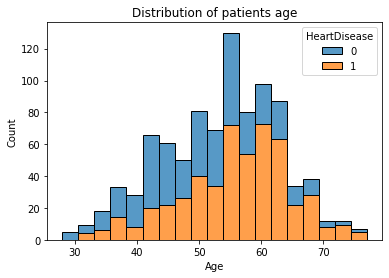

In [ ]:
# Histogram for Age feature
sns.histplot(data = heart_df, x = 'Age', hue="HeartDisease", multiple="stack").set(title = 'Distribution of patients age')
plt.show()

As common knowledge suggests, the distribution is left-skewed, meaning the majority of patients belong to the high-age side of the distribution (people over 50 years old).




#### Resting blood pressure feature

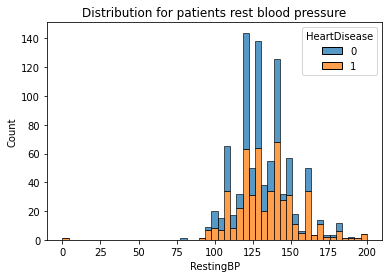

In [ ]:
# Histogram for RestingBP
sns.histplot(data = heart_df, x = 'RestingBP', hue="HeartDisease", multiple="stack").set(title = 'Distribution for patients resting blood pressure')
plt.show()

- The zero value for RestingBP is wrong. Only a dead person would have a null resting blood pressure, so we must clean it.

#### Cholesterol feature

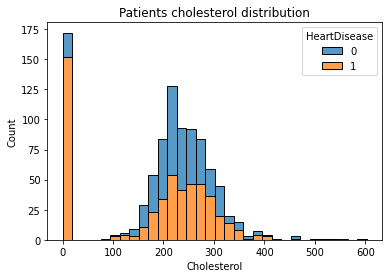

In [ ]:
# Histogram for Cholesterol
sns.histplot(data = heart_df, x = 'Cholesterol', hue="HeartDisease", multiple="stack").set(title = 'Patients cholesterol distribution')
plt.show()

- There are many patients with zero cholesterol. We already knew from the summary statistics of the data that some of them would be zero, but now it is clear how many.

- The mean and median values suggested a left-skewed distribution (when the median is higher than the mean). However, if we exclude zeros, the distribution looks like a right-skewed distribution. 

- It is not possible to have people with zero cholesterol. We must clean those values later on. 

#### Maximum heart rate feature

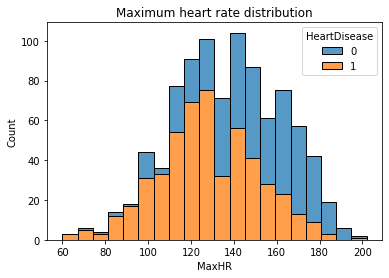

In [ ]:
# Histogram for MaxHR
sns.histplot(data = heart_df, x = 'MaxHR', hue="HeartDisease", multiple="stack").set(title = "Maximum heart rate distribution")
plt.show()

- The distribution for the maximum heart rate is slightly left-skewed. 

- The lower the maximum heart rate, the more likely a patient is positive for CVD. That's probably because the patients felt some discomfort as soon as the heart rate started increasing.

#### Oldpeak feature

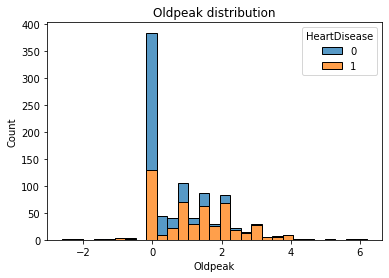

In [ ]:
# Histogram for Oldpeak
sns.histplot(data= heart_df, x = 'Oldpeak', hue="HeartDisease", multiple="stack").set(title='Oldpeak distribution')
plt.show()

- The oldpeak definition is the ST depression induced by exercise relative
to rest. Values for ST depression that are < -0.5 or > 0.5 are a good indicator that something is wrong. In fact, [ST depression greater than 1 mm is often a sign of myocardial ischemia or angina](https://www.ncbi.nlm.nih.gov/books/NBK549803/).

- The histogram above shows explicitly what the domain knowledge suggested.


### Categorical variables

To visualize which categories are correlated with heart disease, we will plot some histograms for the categorical variables grouped by the patients diagnosed with CVD.


#### FastingBS feature

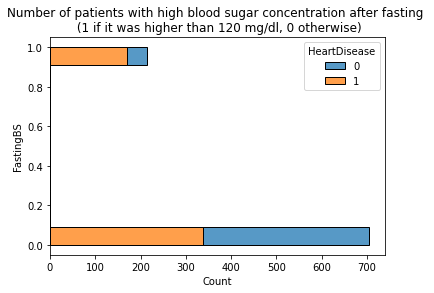

In [ ]:
# Histogram for FastingBS
sns.histplot(data = heart_df, y = 'FastingBS', hue="HeartDisease", multiple="stack").set(title = 'Number of patients with high blood sugar concentration after fasting \n (1 if it was higher than 120 mg/dl, 0 otherwise)')
plt.show()

- Most people have less than 120 mg/dl of sugar in their blood. 

- [Domain knowledge](https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html) establishes a correlation between the level of sugar in one's blood and the risk for CVDs.

- More than 50% of patients with high fasting blood sugar were diagnosed with heart disease.

#### Sex feature

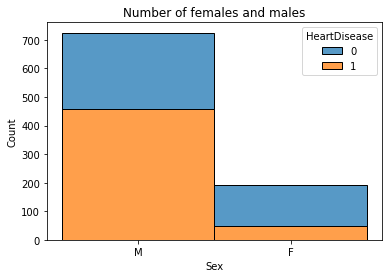

In [ ]:
# Histogram for Sex variable
sns.histplot(data = heart_df, x = 'Sex', hue="HeartDisease", multiple="stack").set(title = 'Number of females and males')
plt.show()

- Most of the patients in this dataset are males. 

- [Domain knowledge](https://www.health.harvard.edu/heart-health/throughout-life-heart-attacks-are-twice-as-common-in-men-than-women) establishes that men are twice more likely to develop heart diseases than women. [It also suggests that men tend to develop heart diseases ten years earlier than women](https://www.hopkinsmedicine.org/health/wellness-and-prevention/special-heart-risks-for-men). 

- According to the histogram above, ~ 63% of men were positive for CVDs, while ~ 25% of women were positive. In other words, men are roughly 2.5 times more likely to suffer from heart disease. Given that this is a small sample, it corroborates with domain knowledge.

- The uneven distribution for men than women can induce bias in machine learning modeling. We need to be aware of that later on.


What if we choose only people over 50 years old?

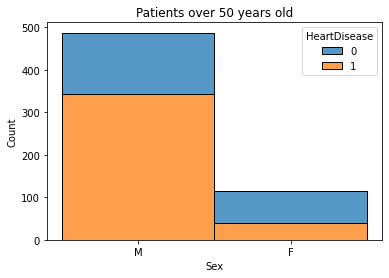

In [ ]:
# Histogram for patients > 50 years old
sns.histplot(data = heart_df[heart_df['Age']> 50], x = 'Sex', hue = 'HeartDisease', multiple = 'stack').set(title = 'Patients over 50 years old')
plt.show()

In [ ]:
# Number for males over fifty grouped by the target variable
heart_df[(heart_df['Age']> 50) & (heart_df['Sex'] == 'M')].groupby(['HeartDisease']).sum()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
HeartDisease,,,,,,
0,8214,18985,29186,28,20094,77.6
1,20572,46652,56566,129,42371,462.7


In [ ]:
# Number for females over fifty grouped by the target variable
heart_df[(heart_df['Age']> 50) & (heart_df['Sex'] == 'F')].groupby(['HeartDisease']).sum()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
HeartDisease,,,,,,
0,4437,10095,20267,9,10942,43.0
1,2326,5650,9053,12,5371,53.5


The percentage of men over 50 years old diagnosed with CVD is around 71%, while only ~34% of women were diagnosed with CVD. It also corroborates with domain knowledge.

In [ ]:
# Distribution for the Sex variable
heart_df['Sex'].value_counts(normalize = True)*100

M    78.976035
F    21.023965
Name: Sex, dtype: float64

- Around 79% of the patients are male in this sample.



#### Chest pain feature

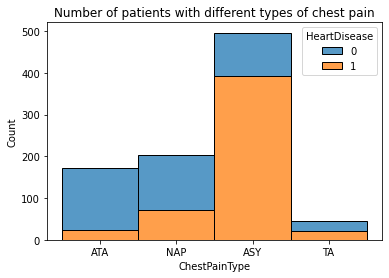

In [ ]:
# Histogram for ChestPainType
sns.histplot(data = heart_df, x = 'ChestPainType', hue="HeartDisease", multiple="stack").set(title = 'Number of patients with different types of chest pain')
plt.show()

- Most of the patients were asymptomatic. The other three types of chest pain stand for:

ATA - Atypical Angina

TA: Typical Angina, 

NAP: Non-Anginal Pain.

- Angina chest pain is caused by reduced blood flow to the heart. [It is often described as squeezing, pressure, heaviness, tightness, or pain in the chest](https://www.mayoclinic.org/diseases-conditions/angina/symptoms-causes/syc-20369373).

- Around 50% of the typical angina patients are positive, while a smaller proportion of the non-anginal or atypical angina pain ends up being positive patients.


#### RestingECG feature

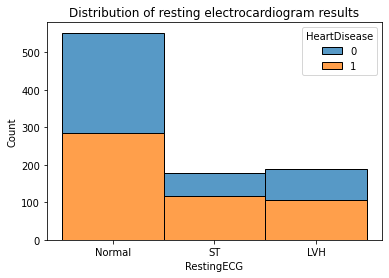

In [ ]:
# Histogram for RestingECG
sns.histplot(data = heart_df, x = 'RestingECG', hue="HeartDisease", multiple="stack").set(title = 'Distribution of resting electrocardiogram results')
plt.show()

- Most patients showed no abnormalities on the resting electrocardiogram results. However, ~50% of them were still positive for CVD.

- Less than 200 patients had an ST positive result, meaning ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV). Also, less than 200 patients were positive for left ventricular hypertrophy (LVH), showing probable or definite LVH by Estes' criteria.

- The data shows that a patient with an ST positive result has a slightly higher chance of being diagnosed with CVD than patients with a left ventricular hypertrophy positive result.

#### ExerciseAngina feature

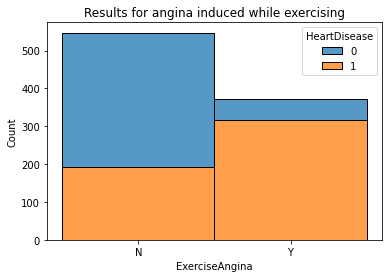

In [ ]:
# Histogram for ExerciseAngina
sns.histplot(data = heart_df, x = 'ExerciseAngina', hue="HeartDisease", multiple="stack").set(title = 'Results for angina induced while exercising')
plt.show()

- More than 500 patients did not suffer from pain while exercising.

- Patients that developed angina while exercising are very likely to suffer from heart disease.

#### ST_Slope feature

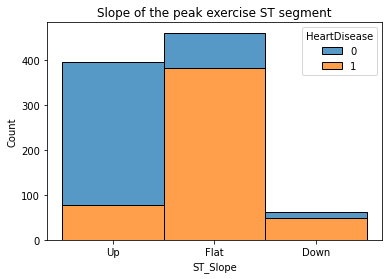

In [ ]:
# Histogram for ST_Slope
sns.histplot(data = heart_df, x ='ST_Slope', hue="HeartDisease", multiple="stack").set(title = 'Slope of the peak exercise ST segment')
plt.show()

- [Domain knowledge](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1123032/) establishes that patients showing a downsloping ST segment depression have a high probability of coronary disease.

- The data corroborate with domain knowledge. It also shows that patients with a flat slope of the ST segment at peak exercise have a higher correlation with CVD.


#### Target variable (HeartDisease)

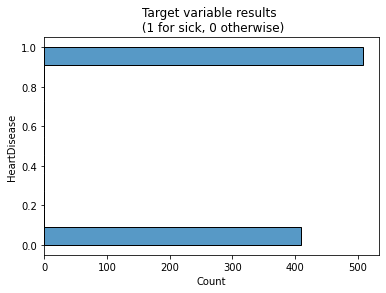

In [ ]:
# Histogram for HeartDisease
sns.histplot(data = heart_df, y = 'HeartDisease').set(title = 'Target variable results \n (1 for sick, 0 otherwise)')
plt.show()

The target variable seems roughly evenly distributed. Let's check the percentage:

In [ ]:
# Distribution of positive and negative values for the target variable
heart_df['HeartDisease'].value_counts(normalize = True)*100

1    55.337691
0    44.662309
Name: HeartDisease, dtype: float64

## Missing values

Let's check if there are any missing values:

In [ ]:
heart_df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

No action needed.

## Data cleaning

The data exploration showed that there are no missing values. However, some values in the 'Cholesterol' and 'RestingBP' features need to be modified. Let's look at them: 

In [ ]:
# Patients with zero resting blood pressure
heart_df[heart_df['RestingBP'] < 10]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [ ]:
# Patients with zero cholesterol
heart_df[heart_df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


Only one patient has zero resting blood pressure and 172 patients have null results for the cholesterol.

The most common ways to replace data like that are:

- Delete values if the number of rows is small compared to the dataset size.

- Replace the values with the mean of the distribution when the number of rows is relatively high.

- Replace the values with the mean of the distribution after grouping it, for example, using the age feature or any other feature that might be relevant according to the data.

We will use the last approach, which will probably keep the overall quality of the data.

In [ ]:
# Creating a dataset for male and female patients
male = heart_df[heart_df['Sex'] == 'M']
female = heart_df[heart_df['Sex'] == 'F']

In [ ]:
male.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000
mean,53.782069,132.445517,187.513103,0.259310,134.325517,0.945517,0.631724
std,9.397864,18.286739,112.351444,0.438559,25.719191,1.087154,0.482670
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,156.000000,0.000000,117.000000,0.000000,0.000000
50%,55.000000,130.000000,219.000000,0.000000,134.000000,0.800000,1.000000
75%,60.000000,140.000000,261.000000,1.000000,152.000000,1.700000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,5.600000,1.000000


In [ ]:
female.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,52.492228,132.212435,241.196891,0.134715,146.139896,0.668912,0.259067
std,9.517593,19.392638,85.195441,0.342307,22.154902,0.956865,0.439262
min,30.000000,94.000000,0.000000,0.000000,90.000000,0.000000,0.000000
25%,46.000000,120.000000,204.000000,0.000000,130.000000,0.000000,0.000000
50%,53.000000,130.000000,243.000000,0.000000,150.000000,0.000000,0.000000
75%,60.000000,140.000000,288.000000,0.000000,163.000000,1.100000,1.000000
max,76.000000,200.000000,564.000000,1.000000,192.000000,6.200000,1.000000


- The maximum and the minimum age for men are, respectively, 77 and 28 years old. That means a gap of 49 years between the maximum and the minimum values. We will divide the male patients into intervals of 7 years each.

- For the women, the maximum age is 76 while the minimum is 30, and we will also split this dataset into intervals of 7 years.

In [ ]:
# Let's make a copy of the dataframe before replacing the data
heartDF = heart_df.copy()

In [ ]:
# Calculate the median for different age intervals for male patients
men_list = [28,35,42,49,56,63,70]
for age in men_list:
  median = male.loc[(male['Age'] >= age) & (male['Age'] <= age + 7) & (male['Cholesterol'] != 0),'Cholesterol'].median()
  heartDF.loc[(heartDF['Sex'] == 'M') & (heartDF['Age'] >= age) & (heartDF['Age'] <= age + 7) & (heartDF['Cholesterol'] == 0), 'Cholesterol'] = median

In [ ]:
# Calculate the median for different age intervals for female patients
women_list = [30,37,44,51,58,65,72]
for age in women_list:
  median = female.loc[(female['Age'] >= age) & (female['Age'] <= age + 7) & (female['Cholesterol'] != 0),'Cholesterol'].median()
  try:
    heartDF.loc[(heartDF['Sex'] == 'F') & (heartDF['Age'] >= age) & (heartDF['Age'] <= age + 7) & (heartDF['Cholesterol'] == 0), 'Cholesterol'] = median
  except:
    pass

For the zero value for resting blood pressure, we will also use the median of the same groups defined above:

In [ ]:
# Replacing zero value for the only zero blood pressure patient
median = male.loc[(male['Age'] >= 49) & (male['Age'] <= 56) & (male['RestingBP'] != 0),'RestingBP'].median()
heartDF.loc[449, 'RestingBP'] = median

In [ ]:
heartDF.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.538126,242.762527,0.233115,136.809368,0.887364,0.553377
std,9.432617,17.990127,53.634662,0.423046,25.460334,1.066570,0.497414
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,232.500000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,268.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


All values were correctly replaced. Let's visualize the distributions for these two variables once more:

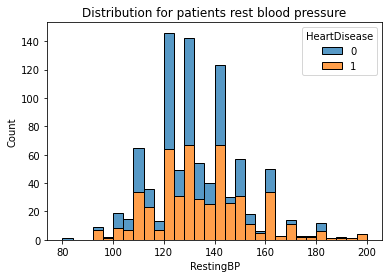

In [ ]:
# Histogram for RestingBP
sns.histplot(data = heartDF, x = 'RestingBP', hue="HeartDisease", multiple="stack").set(title = 'Distribution for patients rest blood pressure')
plt.show()

- The median for this distribution is smaller than the mean, indicating a right-skewed distribution, as we predicted.

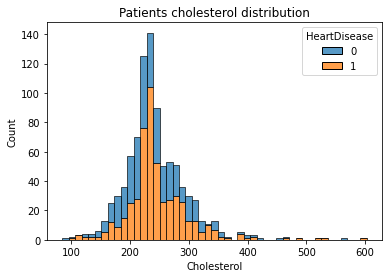

In [ ]:
# Histogram for Cholesterol
sns.histplot(data = heartDF, x = 'Cholesterol', hue="HeartDisease", multiple="stack").set(title = 'Patients cholesterol distribution')
plt.show()

## Feature selection

Let's compute Pearson's r coefficient and search for linear correlations between the features and the target variable. That can serve as a guide to choosing good features for machine learning later on.

In [ ]:
abs(heartDF.corr()['HeartDisease']).nlargest(n=10)

HeartDisease    1.000000
Oldpeak         0.403951
MaxHR           0.400421
Age             0.282039
FastingBS       0.267291
RestingBP       0.117798
Cholesterol     0.070578
Name: HeartDisease, dtype: float64

From the exploratory data analysis, some potential columns to use in machine learning modeling are:

- Oldpeak
- MaxHR
- Age
- FastingBS
- ST slope
- Exercise angina
- Cholesterol

OBS: Even though Cholesterol didn't show a higher correlation with HeartDisease, it was expected by [domain knowledge](), which states that the risk of dying of heart disease has a non-linear correlation with cholesterol. With that in mind, we also included it as one of the features.

ST slope and Exercise angina do not show in the correlation table.That is expected since they are categorical variables and need to be transformed into dummy indices. Let's do that and check if we guessed it right:

In [ ]:
# Replace categorical values for the 'Sex' feature
heartDF['Sex'] = heartDF['Sex'].apply(lambda x: 0 if x == 'M' else 1)

In [ ]:
# Replace categorical values for the 'ExerciseAngina' feature
heartDF['ExerciseAngina'] = heartDF['ExerciseAngina'].apply(lambda x : 1 if x == 'Y' else 0)

In [ ]:
# Create dummy variables for the categorical features 'ChestPainType', 'RestingECG' and 'ST_Slope'
heartDF = pd.get_dummies(data = heartDF, columns = ['ChestPainType','RestingECG','ST_Slope'], drop_first= True)

In [ ]:
# Compute Pearson's r coefficient
abs(heartDF.corr()['HeartDisease']).nlargest(n=20)

HeartDisease         1.000000
ST_Slope_Up          0.622164
ST_Slope_Flat        0.554134
ExerciseAngina       0.494282
Oldpeak              0.403951
ChestPainType_ATA    0.401924
MaxHR                0.400421
Sex                  0.305445
Age                  0.282039
FastingBS            0.267291
ChestPainType_NAP    0.212964
RestingBP            0.117798
RestingECG_ST        0.102527
RestingECG_Normal    0.091580
Cholesterol          0.070578
ChestPainType_TA     0.054790
Name: HeartDisease, dtype: float64

As we predicted from the data exploration, there is a high correlation between CVD with ST_Slope and ExerciseAngina.

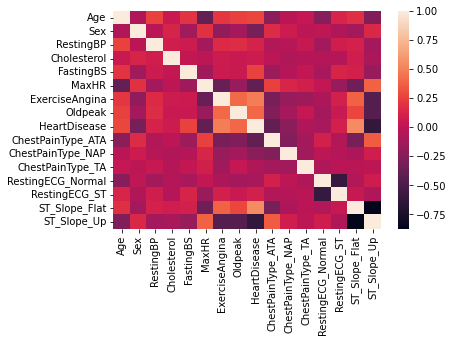

In [ ]:
sns.heatmap(heartDF.corr())
plt.show()

If we follow just Pearson's correlation values, we should choose the following nine features for modeling:

- ST_Slope_Up          
- ST_Slope_Flat        
- ExerciseAngina  
- Oldpeak              
- ChestPainType_ATA    
- MaxHR                
- Sex              
- Age                  
- FastingBS

However, from the heatmap:

1 - ST_Slope_Up and ST_Slope_Flat are strongly correlated, so we can choose only one of these features and avoid redundancies. 

2 - Age has a strong correlation with ST_Slope_Up, RestingECG_Normal, ChestPainType_ATA, and MaxHR. 

3 - Sex has a strong correlation with ExerciseAngina and Oldpeak and FastingBS. Since Sex is an uneven variable, we will not use it to exclude possible features to train the model.

4 - FastingBS has a strong correlation with ST_Slope_UP, RestingECG_Normal, ChestPainType_ATA, and MaxHR.

We are left with the following features:

- ST_Slope_Flat
- ExerciseAngina
- Oldpeak
- Sex
- Age
- FastingBS
- Cholesterol


#### Split-Apply-Combine method for feature selection

To double-check, if we found an optimal choice of features, we will use the split-apply-combine method to check for the values of the means of all features grouped by the target variable.

In [ ]:
# Split-apply-combine method
heartDF.groupby('HeartDisease').agg(
    {
        'ST_Slope_Up': 'mean',         
        'ST_Slope_Flat': 'mean',        
        'ExerciseAngina': 'mean',
        'Oldpeak': 'mean',
        'ChestPainType_ATA': 'mean',
        'MaxHR': 'mean',           
        'Sex': 'mean',
        'Age': 'mean',
        'FastingBS': 'mean',
        'ChestPainType_NAP': 'mean',
        'RestingBP': 'mean',
        'RestingECG_ST': 'mean',
        'RestingECG_Normal': 'mean',
        'Cholesterol': 'mean',
        'ChestPainType_TA': 'mean'  
    }
)

,ST_Slope_Up,ST_Slope_Flat,ExerciseAngina,Oldpeak,ChestPainType_ATA,MaxHR,Sex,Age,FastingBS,ChestPainType_NAP,RestingBP,RestingECG_ST,RestingECG_Normal,Cholesterol,ChestPainType_TA
HeartDisease,,,,,,,,,,,,,,,
0,0.773171,0.192683,0.134146,0.408049,0.363415,148.151220,0.348780,50.551220,0.107317,0.319512,130.180488,0.148780,0.651220,238.551220,0.063415
1,0.153543,0.750000,0.622047,1.274213,0.047244,127.655512,0.098425,55.899606,0.334646,0.141732,134.440945,0.230315,0.561024,246.161417,0.039370


The split-apply-combine procedure shows a reasonable separation between the mean values for the ChestPainType_NAP feature. That suggests it could be a potential variable for modeling as well. However, the correlation coefficient and our exploratory analysis pointed out against it. So we will use only the features selected in the previous section.

# Building a classifier

We will use accuracy as our metric in this project. It is a standard metric when the label for the target variable is evenly distributed, as is the case here. However, it does not account for errors (false positives and false negatives). In medicine, a false positive means a patient that tested positive but does not suffer from the disease. It can distress the patient psychologically and physically since it might require extra, more intrusive tests to confirm the diagnosis. A false negative could mean the patient's death. Having that in mind, we will also explore [alternative metrics](https://colab.research.google.com/drive/1i7Y8YV_nQxqVEsoBVU7hI219bE2-I3wB#scrollTo=jxoC9aBI3gZU) to guide us along this project.

We will build different models for predicting CVDs, starting with the K-nearest neighbors algorithm.

## K-Nearest Neighbors classifier


In [ ]:
# Defining feature and target spaces
X = heartDF[['ST_Slope_Up','ExerciseAngina','Oldpeak', 'Sex', 'Age', 'FastingBS', 'Cholesterol']]
y = heartDF['HeartDisease']

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 48, stratify= X['Sex'])

In [ ]:
# Split part of the train set (20% of X) as test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2*X.shape[0]/X_train.shape[0], random_state = 48, stratify= X_train['Sex'])

We used stratify for the 'Sex' feature to ensure the uneven representation of males and females on the original dataset is kept once we split the data into training, validation, and test sets. It avoids introducing extra bias in the model (more males in the training set could lead to better accuracy in the validation set but would underperform in the test set, which would have more females, for example).

Before checking how the model performs using all features, we will test it in each of the features below:

In [ ]:
features = ['ST_Slope_Up','ExerciseAngina','Oldpeak', 'Sex', 'Age', 'FastingBS','Cholesterol']

for feature in features:
  # Instantiate a knn classifier 
  knn = KNeighborsClassifier(n_neighbors= 5)
  knn.fit(X_train[[feature]], y_train)
  score = knn.score(X_val[[feature]], y_val)
  print(f'The accuracy on the validation set, using only the {feature} feature was {score*100:.2f}%.')

The accuracy on the validation set, using only the ST_Slope_Up feature was 73.91%.
The accuracy on the validation set, using only the ExerciseAngina feature was 72.28%.
The accuracy on the validation set, using only the Oldpeak feature was 68.48%.
The accuracy on the validation set, using only the Sex feature was 70.11%.
The accuracy on the validation set, using only the Age feature was 50.00%.
The accuracy on the validation set, using only the FastingBS feature was 53.80%.
The accuracy on the validation set, using only the Cholesterol feature was 57.07%.


Among the models built with only one feature, we had:

- The 'ST_Slop_Up' feature with the highest correlation with the target variable also provided the best model with 73.91% accuracy on the validation set. 

- The model using only the 'Oldpeak' feature performed worse (68.48% accuracy on the validation set) than the models using only the 'Sex' feature (70.11% accuracy) even though Oldpeak has a significantly higher linear correlation with the target variable.

- Surprisingly, the 'Age' feature had the worse performance (50% accuracy).


We will now build a model using all features. The KNN algorithm uses the distances of neighbors to compute the accuracy. It is then crucial to normalize all feature values to avoid favoring the ones with more sparsed values. We will use a scaler to normalize the values:

In [ ]:
# Instantiate a scaler
scaler = MinMaxScaler()

In [ ]:
# Scaling training, validation and test sets
X_train_scaled = scaler.fit_transform(X_train[['ST_Slope_Up','ExerciseAngina','Oldpeak', 'Sex', 'Age', 'FastingBS','Cholesterol']])
X_val_scaled = scaler.fit_transform(X_val[['ST_Slope_Up','ExerciseAngina','Oldpeak', 'Sex', 'Age', 'FastingBS','Cholesterol']])
X_test_scaled = scaler.fit_transform(X_test[['ST_Slope_Up','ExerciseAngina','Oldpeak', 'Sex', 'Age', 'FastingBS','Cholesterol']])

In [ ]:
# Building a model with all features and testing its accuracy on the validation test
knn = KNeighborsClassifier(n_neighbors= 5)
knn.fit(X_train_scaled, y_train)
score = knn.score(X_val_scaled, y_val)
print(f'The accuracy on the validation set, using all features was: {score*100:.2f}%.')

The accuracy on the validation set, using all features was: 79.89%.


The accuracy, using all features, was 79.9%. It improved in relation to the 73.9% accuracy using only the ST_Slope_Up feature. However, we can try to do better by using GridSearch.

## Hyperparameter Tuning

In [ ]:
# Define parameter space
grid_params = {'n_neighbors': range(1,100), 
               'p': [1, 2, 3]}

# Instantiate a classifier
knn = KNeighborsClassifier()

In [ ]:
# Search for best parameters
knn_grid = GridSearchCV(knn, param_grid= grid_params, scoring = 'accuracy')

# Fit model using best parameters
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100), 'p': [1, 2, 3]},
             scoring='accuracy')

In [ ]:
# Check the metric used for the scoring
knn_grid.scorer_

make_scorer(accuracy_score)

In [ ]:
# print best parameters and score
print(f'The best parameters were given by {knn_grid.best_params_}.')
print(f'The best score was {knn_grid.best_score_*100:.2f}%.')

The best parameters were given by {'n_neighbors': 39, 'p': 1}.
The best score was 87.27%.


- With 39 neighbors and p = 1 (Manhattan metric), the best model had an f1-score of ~87.3%. 

- It delivered a better result than the model we built using only 5 neighbors and p=2. 

- GridSearch performs cross-validation under the hood and is more likely to better estimate how the model will perform in the test set.

## Model evaluation on test set

In [ ]:
# Find score for test set
accuracy = knn_grid.best_estimator_.score(X_test_scaled,y_test)

In [ ]:
print(f'The model accuracy on the test set was {accuracy*100:.2f}%.')

The model accuracy on the test set was 86.96%.


The model's accuracy was ~87% on the test set. Very close to the 87.3%  obtained using the training set with GridSearch.

## Logistic regression

We start building a logistic regression model using the train_test_split method from sklearn. We will use it to compute the accuracy, sensitivity, specificity, PPV, and NPV metrics. We will also use it to analyze the model's coefficients and check if the chosen features will contribute to the model's performance.

Later, we will perform cross-validation to obtain more realistic values for the model's accuracy. We will also compute the [f1-score](https://colab.research.google.com/drive/1i7Y8YV_nQxqVEsoBVU7hI219bE2-I3wB#scrollTo=jxoC9aBI3gZU), which contains information about the wrong predictions made by the model.


In [ ]:
from sklearn.linear_model import LogisticRegression

# Split features and target
X = heartDF[['ST_Slope_Up','ExerciseAngina','Oldpeak', 'Sex', 'Age', 'FastingBS', 'Cholesterol']]
y = heartDF['HeartDisease']

In [ ]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state= 48, stratify= X['Sex'])

# Split the training set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2*X.shape[0]/X_train.shape[0], random_state = 48, stratify = X_train['Sex'])

In [ ]:
# Instantiate a model
lr = LogisticRegression(max_iter = 200)

# Fit logistic regression model
lr.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [ ]:
# Compute accuracy validation set
accuracy_val = lr.score(X_val, y_val)
print(f'The accuracy on the validation set was {accuracy_val*100:.2f}%.')

The accuracy on the validation set was 79.89%.


We did split the data into training, validation, and test sets. It is good practice to do so once we start iterating the model. However, in this project, we will stick with the features we chose and move on to check the accuracy of the test set.

In [ ]:
# Accuracy on the test set
accuracy_test = lr.score(X_test,y_test)

print(f'The accuracy on the test set was: {accuracy_test*100:.2f}%.')

The accuracy on the test set was: 86.96%.


The model's performance on the validation set for the logistic regression model was the same as on the validation set using the K-NN algorithm (~79.9% accuracy). It was considerably faster to train a logistic regression model than a K-NN algorithm. However, K-NN took longer due to the cross-validation and the grid search, which tends to be more precise than a single split into training, validation, and test sets that we used for the logistic regression model.

Another problem with not performing cross-validation is that the values for the accuracy of the validation and test sets are very different as we noticed above. The mean of the cross-validation scores tends to be a more realistic score on new data. We will perform cross-validation in the next section.


Let's compute the sensitivity, specificity, positive predictive value, and negative predictive values for this model. It will help us to understand the  f1-score result later on.

In [ ]:
# Compute true positives
tp = sum((lr.predict(X_train) == 1) & (y_train ==1))
print(f'The number of true positives was, {tp}.')

# Compute true negatives
tn = sum((lr.predict(X_train) == 0) & (y_train == 0))
print(f'The number of true negatives was {tn}.')

# Compute false positives
fp = sum((lr.predict(X_train) == 1) & (y_train == 0))
print(f'The number of false positives was, {fp}.')

# Compute false negatives
fn = sum((lr.predict(X_train) == 0) & (y_train == 1))
print(f'The number of false negatives was, {fn}.')


The number of true positives was, 270.
The number of true negatives was 209.
The number of false positives was, 39.
The number of false negatives was, 32.


In [ ]:
# Compute sensitivity
sensitivity = tp/(tp + fn)
print(f'The sensitivity of the model was: {sensitivity*100:.2f}%.')

# Compute specificity
specificity = tn/(tn + fp)
print(f'The specificity of the model was: {specificity*100:.2f}%.')

# Compute PPV
PPV = tp/(tp + fp)
print(f'The PPV of the model was: {PPV*100:.2f}%.')

# Compute NPV
NPV = tn/(tn + fn)
print(f'The NPV of the model was: {NPV*100:.2f}%.')

# F1-score

f1_score = 2*sensitivity*PPV/(sensitivity + PPV)
print(f'The f1-score for this model is: {NPV*100:.2f}%.')


The sensitivity of the model was: 89.40%.
The specificity of the model was: 84.27%.
The PPV of the model was: 87.38%.
The NPV of the model was: 86.72%.
The f1-score for this model is: 86.72%.


The model has a sensitivity of 89.40%. A model with high sensitivity is useful to rule out a positive outcome. In other words, [a model with high sensitivity generally has a high NPV](https://colab.research.google.com/drive/1i7Y8YV_nQxqVEsoBVU7hI219bE2-I3wB). In fact, a patient predicted as negative for CDV using this model has an 86.72% chance of being negative. 

On the other side, the model had a specificity of 84.27%. It is also not bad. [A model with high specificity generally has a high PPV](https://colab.research.google.com/drive/1i7Y8YV_nQxqVEsoBVU7hI219bE2-I3wB) In fact, patients that predicted as positive for CDV using this model have an 87.38% chance of being positive.

#### Logistic regression parameters

To interpret the logistic regression parameters, we need to remember how the features impact the probability of predicting a label for the outcome. That is given by:
$$
log(\frac{EY}{1-EY}) = \alpha + \beta*X.
$$
From this we can [derive](https://colab.research.google.com/drive/1Ksc9An1H85_zUSm90EtZqHdcp85kKH-Z#scrollTo=yhfjjFpApfbv) that the slope $\beta$ is given by:
$$
\beta = log(\frac{Odds(1)}{Odds(0)}),
$$
or
$$
\frac{Odds(1)}{Odds(0)} = e^{\beta},
$$
where
$$
Odds(y) = \frac{EY(y)}{1-EY(y)}.
$$
Let's obtain the slope from the logistic regression model and compute the odds ratio:




In [ ]:
# Retrieve the slope
beta = lr.coef_

# Compute odds ratio
odds_ratio = np.exp(beta)

print(f'The odds ratio for the logistic regression model are: \n ST_Slope_Up: {odds_ratio[0,0]:.4f}, \n ExerciseAngina: {odds_ratio[0,1]:.4f}, \n Oldpeak: {odds_ratio[0,2]:.4f}, \n Sex: {odds_ratio[0,3]:.4f}, \n Age: {odds_ratio[0,4]:.4f},  \n FastingBS: {odds_ratio[0,5]:.4f}, \n Cholesterol: {odds_ratio[0,6]:.4f}.')

The odds ratio for the logistic regression model are: 
 ST_Slope_Up: 0.0942, 
 ExerciseAngina: 3.6678, 
 Oldpeak: 1.3941, 
 Sex: 0.2036, 
 Age: 1.0254,  
 FastingBS: 3.0655, 
 Cholesterol: 1.0021.


These results make sense. Most of the features have an odds ratio higher than 1. In other words, it is exponentially more likely to have a patient diagnosed as positive if we increase the values for the features by one unit. 

ST_Slope_Up and Sex are categorical variables and do not carry the same meaning as a numerical variable. For example, we are considering the value 0 for male patients and 1 for females. That explains why the odds ratio is smaller than 1. Analogously, for the ST_Slope_Up variable, as one can see from the split-apply-combine section. A higher value for this variable is correlated with negative predictions, while smaller values are correlated with positive predictions.



### KFold cross-validation

We will use the [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) class from sklearn to implement cross-validation and obtain a more realistic value for the accuracy and f1-score metrics.

In [ ]:
from sklearn.model_selection import cross_validate

# Instantiate a model
model = LogisticRegression(max_iter =200)

# Perform cross-validation and compute accuracy and f1-score for the model
multiple_cross_scores = cross_validate(model, 
                                       X, y, cv = 10,
                                       scoring = ('accuracy', 'f1'))

print(multiple_cross_scores)

{'fit_time': array([0.05371141, 0.03676224, 0.06117487, 0.03476787, 0.03566027,
       0.04757953, 0.02911806, 0.08187628, 0.03043771, 0.03145337]), 'score_time': array([0.00428295, 0.00382996, 0.00283504, 0.00280404, 0.00296187,
       0.00294805, 0.00535822, 0.00285769, 0.00281692, 0.00285888]), 'test_accuracy': array([0.84782609, 0.94565217, 0.77173913, 0.88043478, 0.86956522,
       0.82608696, 0.89130435, 0.79347826, 0.74725275, 0.79120879]), 'test_f1': array([0.86      , 0.95145631, 0.76404494, 0.88659794, 0.88888889,
       0.86206897, 0.90740741, 0.81553398, 0.77227723, 0.80808081])}


In [ ]:
# Average accuracy
accuracy_cross_val = multiple_cross_scores['test_accuracy'].mean()
print(f'The average accuracy for the logistic regression model, after performing cross-validation, was: {accuracy_cross_val*100:.2f}%.')

# Average f1-score
f1_cross_val = multiple_cross_scores['test_f1'].mean()
print(f'The average f1-score for the logistic regression model, after performing cross-validation, was: {f1_cross_val*100:.2f}%.')


The average accuracy for the logistic regression model, after performing cross-validation, was: 83.65%.
The average f1-score for the logistic regression model, after performing cross-validation, was: 85.16%.


The accuracy value for the logistic regression model we created was 83.65%. In other words, the model predicted the correct labels, either positive or negative, in 83.65% of the cases. The f1-score was 85.16%, indicating good sensitivity and positive predictive values. 



# Summary

In this project, we explored, cleaned, and selected features from patients suspected of suffering from cardiovascular diseases (CVDs). We used the cleaned data to build a K-nearest neighbor and a logistic regression model. The highlights from these models are:

- The K-NN model had better performance with an accuracy of ~87.0% on the test against the ~83.6% accuracy for the logistic regression.

- The logistic regression model had an f1-score of 85.16%. It indicates the model is good at selecting positive patients. This model could be relevant in a [screening procedure](https://colab.research.google.com/drive/1i7Y8YV_nQxqVEsoBVU7hI219bE2-I3wB), for example.

- In a real-world scenario, this model performance is not ideal. 87.0% accuracy looks good, but it would mean that 13.0% of the patients got the wrong result. A false positive could distress the patient and lead him/her on a path for treatments that are not needed. A false negative could mean death!

- For the logistic regression model, the f1-score was higher than the accuracy. It is an indication that the model is better at detecting positive cases. That's a desirable feature in medicine. However, ideally, we don't want to misclassify any patients. That could be implemented by increasing the number of labels for the outcomes, which would lead to a multi-class classification problem. That is beyond the scope of this project.

# Future directions

- We could increase the parameter space to improve the models' performance, collect more data or improve the feature selection before building the classifiers. Feature engineering could also help to improve the performance of a model.

- Increase the number of labels for the outcomes. That could improve the quality of the diagnostics by, for example, sending borderline patients for extra tests.